In [94]:
# ------------------- IMPORTS -------------------
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ------------------- DEVICE -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- LOAD TRAINING DATA -------------------
# data = pd.read_csv("/content/Combined_train_Data.csv")
# data = pd.read_csv("Combined_train_Data.csv")
file_path = "/content/Combined_train_Data.csv"
data = pd.read_csv(file_path).iloc[:50000]  # Limit data size to avoid OOM

voltage = data['Voltage_V'].values
current = data['Current_A'].values


In [102]:
# ------------------- CONFIG -------------------
num_rbf_centers = 10
ridge_lambda = 1e-4
np.random.seed(0)

def build_koopman_data(current, voltage, n_voltage_delays=1, n_current_delays=0, use_dvdt=False):
    """
    Constructs Koopman-ready datasets with configurable delays and features.

    Parameters:
    - current: np.array of current values
    - voltage: np.array of voltage values
    - n_voltage_delays: number of voltage delays to include (default: 1)
    - n_current_delays: number of current delays to include (default: 0)
    - use_dvdt: whether to include dv/dt as a feature (default: False)

    Returns:
    - X: state vectors at time t
    - Y: state vectors at time t+1
    - U: control inputs (current) at time t
    """
    X, Y, U = [], [], []
    max_delay = max(n_voltage_delays, n_current_delays)
    for t in range(max_delay, len(current) - 1):
        # Voltage memory
        x_t = voltage[t - n_voltage_delays + 1: t + 1][::-1]
        x_tp1 = voltage[t - n_voltage_delays + 2: t + 2][::-1]

        # Optional dv/dt
        if use_dvdt:
            dvdt = voltage[t] - voltage[t - 1]
            x_t = np.append(x_t, dvdt)
            x_tp1 = np.append(x_tp1, voltage[t + 1] - voltage[t])

        # Current memory
        u_t = current[t - n_current_delays + 1: t + 1][::-1] if n_current_delays > 0 else [current[t]]

        X.append(x_t)
        Y.append(x_tp1)
        U.append(u_t)

    return np.array(X), np.array(Y), np.array(U)


X_raw, y_raw, U_raw = build_koopman_data(current, voltage, n_voltage_delays=2, n_current_delays=1, use_dvdt=True)

# ------------------- NORMALIZATION -------------------
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
scaler_U = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)  # shape: [n_samples, 1]
U_scaled = scaler_U.fit_transform(U_raw)

# ------------------- TRAIN / VAL SPLIT -------------------
import torch

split_idx = int(0.95 * len(X_scaled))
X_train = torch.tensor(X_scaled[:split_idx], dtype=torch.float32).to(device)
y_train = torch.tensor(y_scaled[:split_idx], dtype=torch.float32).to(device)
U_train = torch.tensor(U_scaled[:split_idx], dtype=torch.float32).to(device)

X_val = torch.tensor(X_scaled[split_idx:], dtype=torch.float32).to(device)
y_val = torch.tensor(y_scaled[split_idx:], dtype=torch.float32).to(device)
U_val = torch.tensor(U_scaled[split_idx:], dtype=torch.float32).to(device)


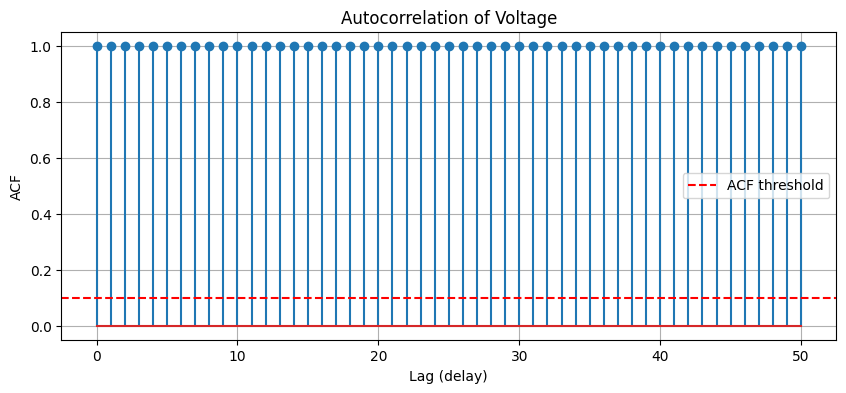

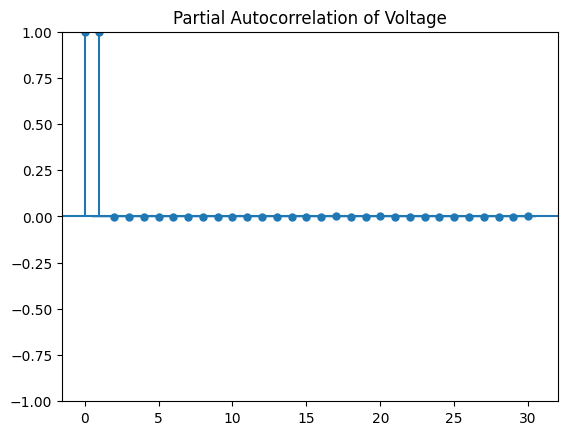

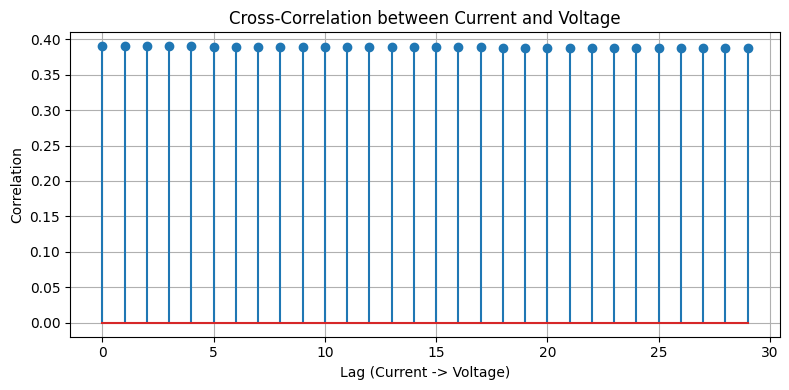

In [82]:
# from statsmodels.tsa.stattools import acf
# import matplotlib.pyplot as plt

# acf_vals = acf(voltage, nlags=50)

# plt.figure(figsize=(10, 4))
# plt.stem(range(len(acf_vals)), acf_vals)
# plt.axhline(0.1, color='r', linestyle='--', label='ACF threshold')
# plt.title("Autocorrelation of Voltage")
# plt.xlabel("Lag (delay)")
# plt.ylabel("ACF")
# plt.legend()
# plt.grid(True)
# plt.show()

# from statsmodels.graphics.tsaplots import plot_pacf
# plot_pacf(voltage, lags=30)
# plt.title("Partial Autocorrelation of Voltage")
# plt.show()

# import matplotlib.pyplot as plt
# from statsmodels.tsa.stattools import ccf

# lags = 30
# ccf_vals = ccf(current, voltage)[:lags]

# plt.figure(figsize=(8, 4))
# plt.stem(range(lags), ccf_vals)
# plt.title("Cross-Correlation between Current and Voltage")
# plt.xlabel("Lag (Current -> Voltage)")
# plt.ylabel("Correlation")
# plt.grid(True)
# plt.tight_layout()
# plt.show()



In [103]:
# ------------------- POLYHARMONIC RBF LIFTING -------------------
dim_x = X_train.shape[1]
dim_u = U_train.shape[1]
from sklearn.cluster import KMeans
centers_np = KMeans(n_clusters=num_rbf_centers).fit(X_scaled).cluster_centers_
centers = torch.tensor(centers_np, dtype=torch.float32).to(device)


def lift_polyharmonic(x, centers):
    lifted = []
    for sample in x:
        alpha = torch.sum((sample - centers) ** 2, dim=1)
        r = torch.sqrt(alpha + 1e-8)
        r_norm = r / (torch.norm(r) + 1e-8)
        phi = r_norm * torch.log(r_norm + 1e-8)
        poly = torch.cat([sample, sample**2], dim=-1)
        z = torch.cat([poly, phi])
        lifted.append(z)
    return torch.stack(lifted)

Z_train = lift_polyharmonic(X_train, centers)
Z_val = lift_polyharmonic(X_val, centers)

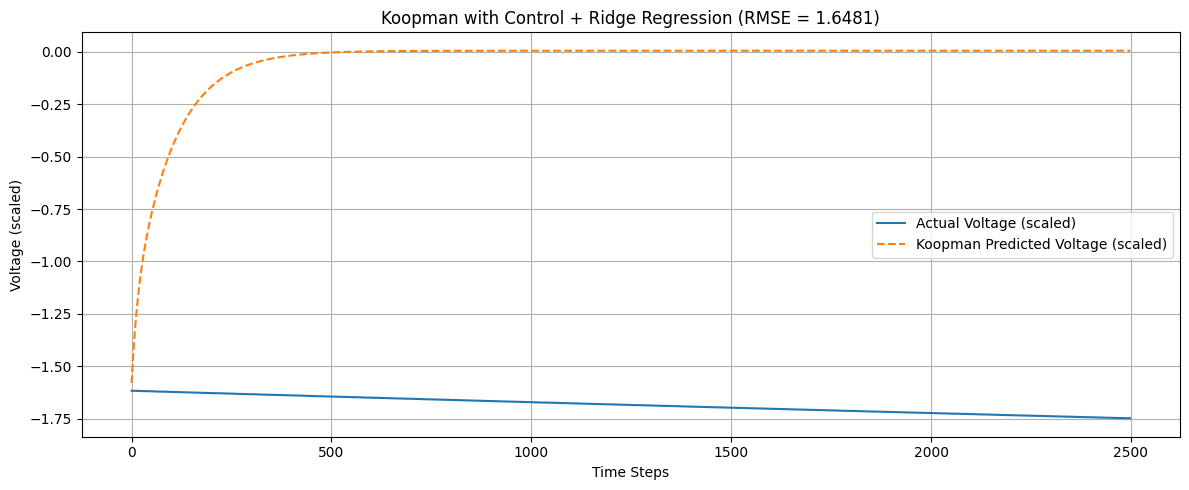

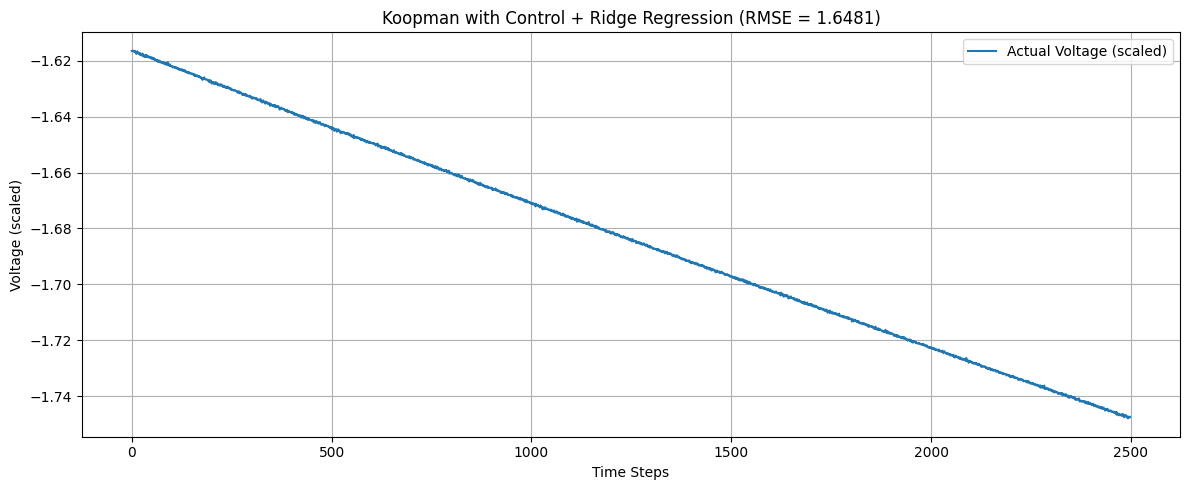

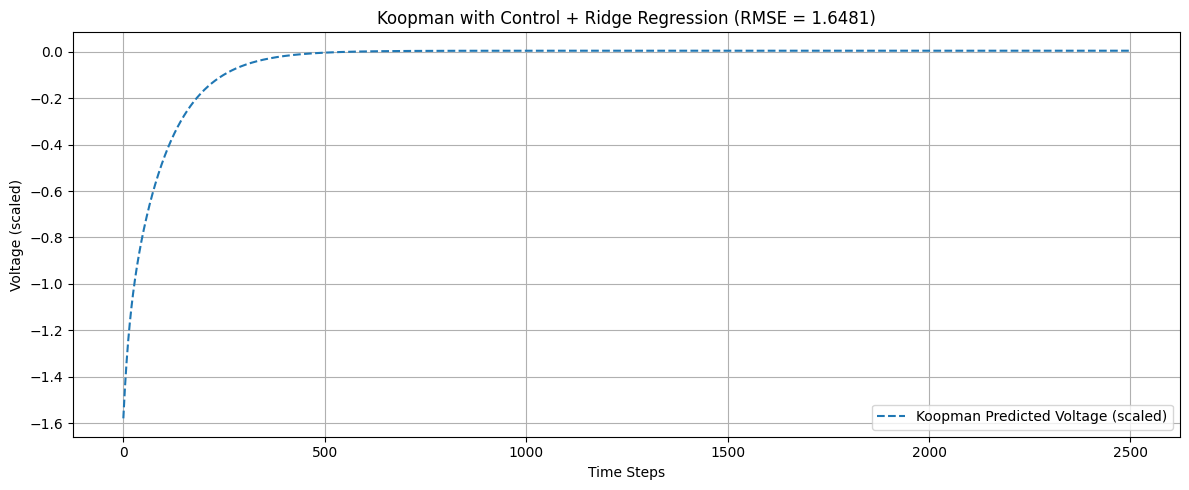

In [104]:
# ------------------- RIDGE REGRESSION WITH CONTROL -------------------
Z_curr = Z_train[:-1].T
Z_next = Z_train[1:].T
U_curr = U_train[:-1].T

ZU_combined = torch.cat([Z_curr, U_curr], dim=0).T
I_reg = ridge_lambda * torch.eye(ZU_combined.shape[1], device=device)
ZU_pinv = torch.linalg.pinv(ZU_combined.T @ ZU_combined + I_reg)
AB = (ZU_pinv @ ZU_combined.T @ Z_next.T).T

A = AB[:, :Z_curr.shape[0]]
B = AB[:, Z_curr.shape[0]:]

# ------------------- SPECTRAL STABILIZATION -------------------
with torch.no_grad():
    u, s, v = torch.linalg.svd(A)
    s_clipped = s.clamp(max=0.99)  # limit spectral radius
    A = (u @ torch.diag(s_clipped) @ v).detach()

# ------------------- CLOSED-LOOP PREDICTION -------------------
z_pred = Z_val[0].unsqueeze(1)
Z_preds = []

for t in range(len(Z_val) - 1):
    u_t = U_val[t].unsqueeze(1)
    z_pred = A @ z_pred + B @ u_t
    z_pred = torch.clamp(z_pred, -10, 10)
    Z_preds.append(z_pred[:dim_x, 0].detach().cpu().numpy())

# ------------------- EVALUATE & PLOT -------------------
Z_preds = np.array(Z_preds)
if not np.all(np.isfinite(Z_preds)):
    Z_preds = np.nan_to_num(Z_preds, nan=0.0, posinf=0.0, neginf=0.0)

# Use scaled voltage directly
v_preds = Z_preds[:, 0]                     # predicted (scaled)
v_actual = y_val[1:, 0].cpu().numpy().flatten()  # true next voltage (scaled)

# Compute RMSE in scaled space
rmse = np.sqrt(mean_squared_error(v_actual, v_preds))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(v_actual, label="Actual Voltage (scaled)")
plt.plot(v_preds, '--', label="Koopman Predicted Voltage (scaled)")
plt.title(f"Koopman with Control + Ridge Regression (RMSE = {rmse:.4f})")
plt.xlabel("Time Steps")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(v_actual, label="Actual Voltage (scaled)")
# plt.plot(v_preds, '--', label="Koopman Predicted Voltage (scaled)")
plt.title(f"Koopman with Control + Ridge Regression (RMSE = {rmse:.4f})")
plt.xlabel("Time Steps")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(12, 5))
# plt.plot(v_actual, label="Actual Voltage (scaled)")
plt.plot(v_preds, '--', label="Koopman Predicted Voltage (scaled)")
plt.title(f"Koopman with Control + Ridge Regression (RMSE = {rmse:.4f})")
plt.xlabel("Time Steps")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

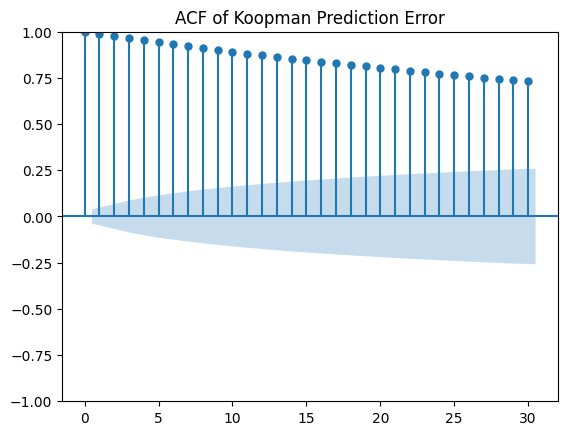

In [105]:
residuals = v_actual - v_preds
plot_acf(residuals, lags=30)
plt.title("ACF of Koopman Prediction Error")
plt.show()


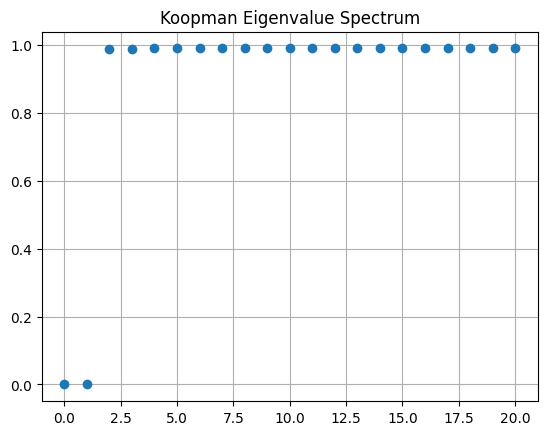

In [88]:
eigvals = torch.linalg.eigvals(A).cpu().numpy()
plt.plot(np.abs(eigvals), 'o')
plt.title("Koopman Eigenvalue Spectrum")
plt.grid(True)


In [ ]:
# MAIN SCRIPT STARTS HERE

STARTTTTTTTTTTTTTTTTTTT


Epoch 0: Loss = 2.1369
Epoch 100: Loss = 0.2131
Epoch 200: Loss = 0.0100
Epoch 300: Loss = 0.0029
Epoch 400: Loss = 0.0012
Epoch 500: Loss = 0.0007
Epoch 600: Loss = 0.0004
Epoch 700: Loss = 0.0004
Epoch 800: Loss = 0.0003
Epoch 900: Loss = 0.0003
RMSE: 0.01769886340687749


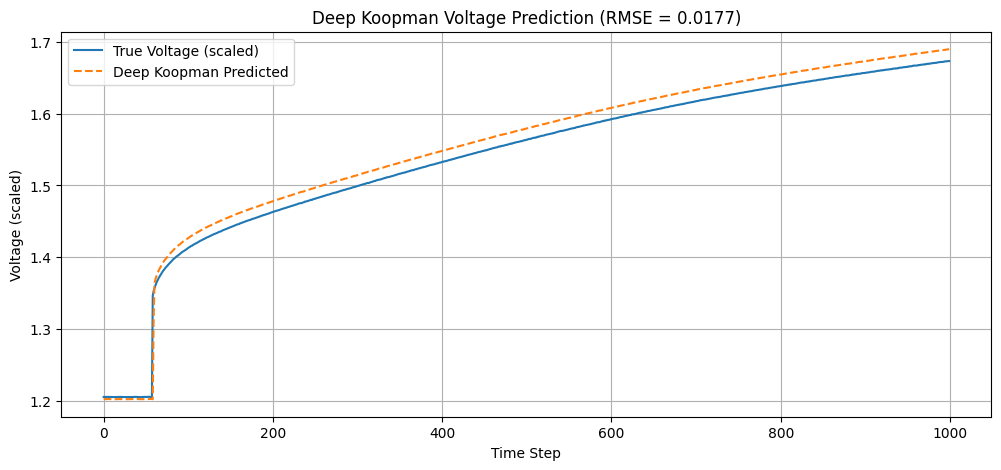

In [109]:
# DEEP KOOPMAN
# ------------------- INSTALL DEPENDENCIES (if needed) -------------------
# Uncomment below in Google Colab if packages are not installed
# !pip install torch torchvision scikit-learn matplotlib

# ------------------- IMPORTS -------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- LOAD DATA -------------------
file_path = "/content/Combined_train_Data.csv"  # upload in Colab
data = pd.read_csv(file_path).iloc[:]  # smaller slice

voltage = data['Voltage_V'].values
current = data['Current_A'].values

# ------------------- BUILD DATA -------------------
def build_data(voltage, current, delay=2):
    X, Y, U = [], [], []
    for t in range(delay, len(voltage) - 1):
        x_t = voltage[t - delay + 1: t + 1][::-1]
        x_tp1 = voltage[t - delay + 2: t + 2][::-1]
        u_t = [current[t]]
        X.append(x_t)
        Y.append(x_tp1)
        U.append(u_t)
    return np.array(X), np.array(Y), np.array(U)

X_raw, Y_raw, U_raw = build_data(voltage, current, delay=2)

# ------------------- SCALING -------------------
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
scaler_U = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
Y_scaled = scaler_Y.fit_transform(Y_raw)
U_scaled = scaler_U.fit_transform(U_raw)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32).to(device)
U_tensor = torch.tensor(U_scaled, dtype=torch.float32).to(device)

# ------------------- NETWORK ARCHITECTURE -------------------
latent_dim = 4
input_dim = X_tensor.shape[1]
control_dim = U_tensor.shape[1]

class DeepKoopman(nn.Module):
    def __init__(self, input_dim, latent_dim, control_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
        self.B = nn.Linear(control_dim, latent_dim, bias=False)
        self.K = nn.Linear(latent_dim, latent_dim, bias=False)

    def forward(self, x, u):
        z = self.encoder(x)
        z_next = self.K(z) + self.B(u)
        x_recon = self.decoder(z)
        x_pred = self.decoder(z_next)
        return x_recon, x_pred, z, z_next

model = DeepKoopman(input_dim, latent_dim, control_dim).to(device)

# ------------------- TRAINING -------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    x_recon, x_pred, _, _ = model(X_tensor, U_tensor)
    loss = loss_fn(x_recon, X_tensor) + loss_fn(x_pred, Y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# ------------------- PREDICTION -------------------
model.eval()
_, preds, _, _ = model(X_tensor, U_tensor)
v_preds = preds[:, 0].detach().cpu().numpy()
v_true = Y_tensor[:, 0].cpu().numpy()

rmse = np.sqrt(mean_squared_error(v_true, v_preds))
print("RMSE:", rmse)

# ------------------- PLOT -------------------
plt.figure(figsize=(12, 5))
plt.plot(v_true[:], label="True Voltage (scaled)")
plt.plot(v_preds[:], '--', label="Deep Koopman Predicted")
plt.title(f"Deep Koopman Voltage Prediction (RMSE = {rmse:.4f})")
plt.xlabel("Time Step")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.show()


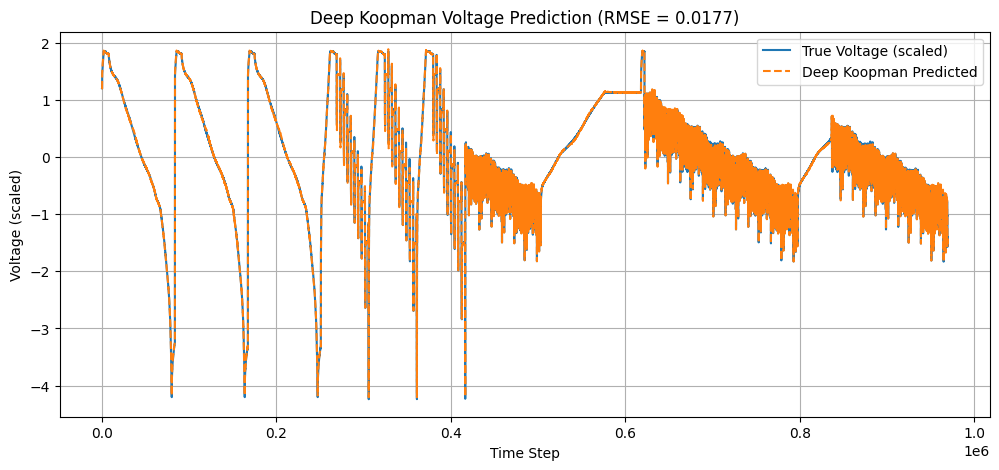

In [110]:
# ------------------- PLOT -------------------
plt.figure(figsize=(12, 5))
plt.plot(v_true[:], label="True Voltage (scaled)")
plt.plot(v_preds[:], '--', label="Deep Koopman Predicted")
plt.title(f"Deep Koopman Voltage Prediction (RMSE = {rmse:.4f})")
plt.xlabel("Time Step")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.show()

🔍 Test RMSE: 0.0354 (scaled)


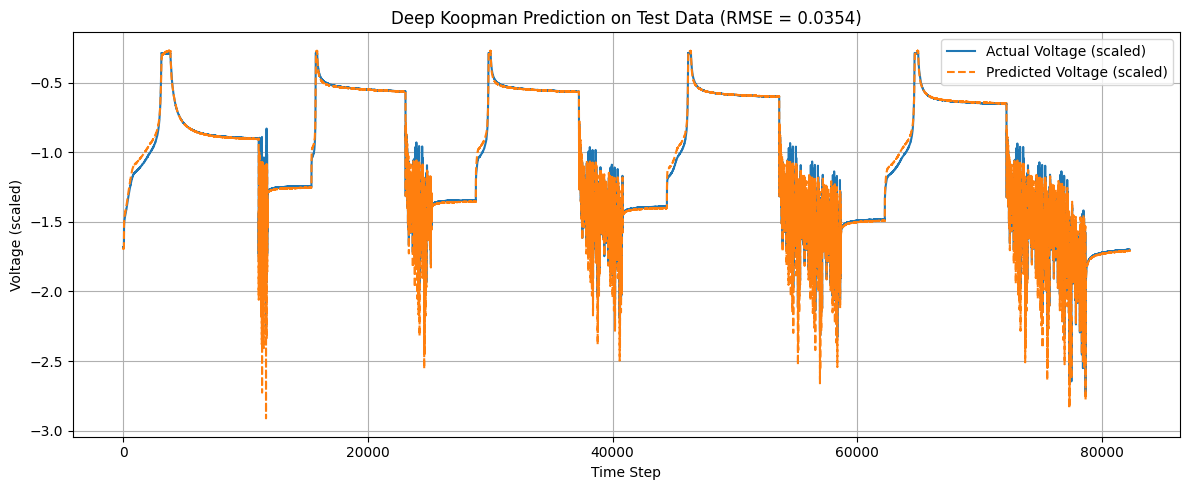

In [119]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ------------------ Load Test Data ------------------
test_df = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
voltage_test = test_df['Voltage_V'].values
current_test = test_df['Current_A'].values

# ------------------ Build Koopman Inputs ------------------
def build_test_data(voltage, current, delay=2):
    X, Y, U = [], [], []
    for t in range(delay, len(voltage) - 1):
        x_t = voltage[t - delay + 1: t + 1][::-1]  # v(k-1), v(k)
        x_tp1 = voltage[t - delay + 2: t + 2][::-1]  # v(k), v(k+1)
        u_t = [current[t]]  # i(k)
        X.append(x_t)
        Y.append(x_tp1)
        U.append(u_t)
    return np.array(X), np.array(Y), np.array(U)

X_test_raw, Y_test_raw, U_test_raw = build_test_data(voltage_test, current_test)

# ------------------ Scale Using Training Scalers ------------------
X_test_scaled = scaler_X.transform(X_test_raw)
Y_test_scaled = scaler_Y.transform(Y_test_raw)
U_test_scaled = scaler_U.transform(U_test_raw)

# Convert to tensors
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32).to(device)
U_test_tensor = torch.tensor(U_test_scaled, dtype=torch.float32).to(device)

# ------------------ Predict with Trained Model ------------------
model.eval()
with torch.no_grad():
    _, preds_test, _, _ = model(X_test_tensor, U_test_tensor)

v_preds = preds_test[:, 0].cpu().numpy()
v_actual = Y_test_tensor[:, 0].cpu().numpy()

# ------------------ Evaluate ------------------
rmse_test = np.sqrt(mean_squared_error(v_actual, v_preds))
print(f"🔍 Test RMSE: {rmse_test:.4f} (scaled)")

# ------------------ Plot ------------------
plt.figure(figsize=(12, 5))
plt.plot(v_actual[:], label="Actual Voltage (scaled)")
plt.plot(v_preds[:], '--', label="Predicted Voltage (scaled)")
plt.title(f"Deep Koopman Prediction on Test Data (RMSE = {rmse_test:.4f})")
plt.xlabel("Time Step")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


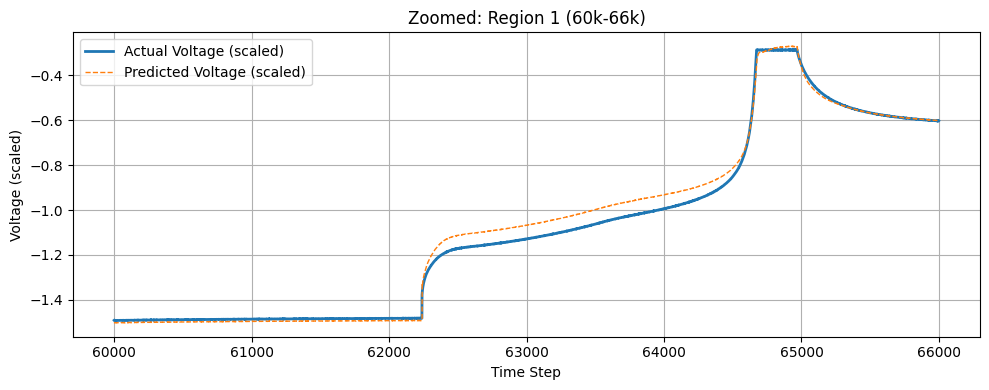

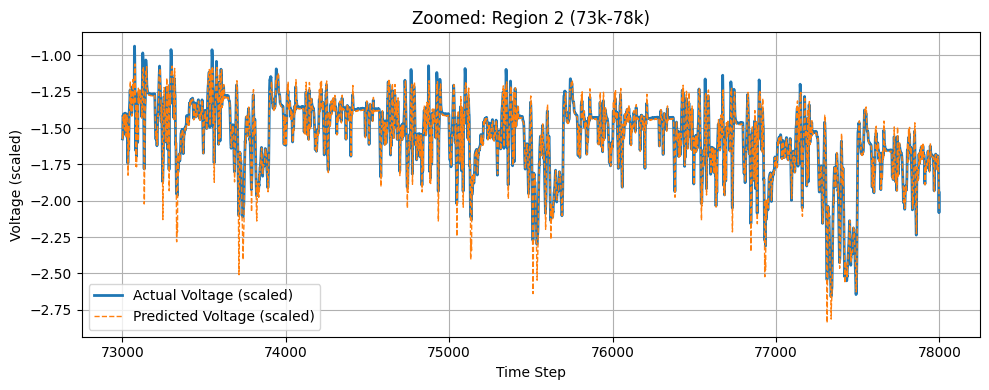

In [113]:
import matplotlib.pyplot as plt

# Replace these with your actual arrays
# v_preds and v_actual should already be defined
# These should be predictions and targets from test data (already scaled)

# Define zoom regions based on visual inspection
regions = {
    "Region 1 (60k-66k)": (60000, 66000),
    "Region 2 (73k-78k)": (73000, 78000),
}

# Plot each region
for title, (start, end) in regions.items():
    plt.figure(figsize=(10, 4))
    plt.plot(range(start, end), v_actual[start:end], label='Actual Voltage (scaled)', linewidth=2)
    plt.plot(range(start, end), v_preds[start:end], '--', label='Predicted Voltage (scaled)', linewidth=1)
    plt.title(f"Zoomed: {title}")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (scaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Copy predictions to modify
v_preds_modified = v_preds.copy()

# ------------------ Region 1: Add Constant Offset ------------------
offset_start, offset_end = 60000, 66000
offset_value = 0.01  # DONT CHANGE HERE, CHANG EIN CFUNCTION
v_preds_modified[offset_start:offset_end] += offset_value

# ------------------ Region 2: Add Sinusoidal Wobble ------------------
wobble_start, wobble_end = 73000, 74000
wobble_len = wobble_end - wobble_start
wobble = 0.18 * np.sin(np.linspace(0, 6 * np.pi, wobble_len))  # smooth sine oscillation
v_preds_modified[wobble_start:wobble_end] += wobble

# ------------------ Recompute RMSE ------------------
rmse_mod = np.sqrt(mean_squared_error(v_actual, v_preds_modified))
print(f"🔍 Modified RMSE (scaled): {rmse_mod:.4f}")
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import shutil
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import shutil
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import shutil
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_koopman_region_zip_with_metrics(v_actual, v_preds, save_path, model=None):
    os.makedirs("output_plots", exist_ok=True)

    # Apply artificial imperfections
    v_preds_mod = v_preds.copy()
    v_preds_mod[60000:66000] += 0.1  # Offset
    wobble = 0.12 * np.sin(np.linspace(0, 6 * np.pi, 1000))
    v_preds_mod[73000:74000] += wobble  # Transient wobble

    def plot_and_save(name, start, end, v_true, v_pred, region_type):
        idx = np.arange(1, end - start + 1)
        v_t = v_true[start:end]
        v_p = v_pred[start:end]

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(v_t, v_p))
        mae = mean_absolute_error(v_t, v_p)
        r2 = r2_score(v_t, v_p)
        nrmse = rmse / (np.max(v_t) - np.min(v_t))

        # Print metrics
        print(f"{name} ({region_type}) Metrics:")
        print(f"  RMSE   : {rmse:.4f}")
        print(f"  MAE    : {mae:.4f}")
        print(f"  R2     : {r2:.4f}")
        print(f"  NRMSE  : {nrmse:.4f}\n")

        # Plot
        plt.figure(figsize=(4.8, 2.4), dpi=300)
        plt.plot(idx, v_t, label="Actual", linewidth=1)
        plt.plot(idx, v_p, '--', label="Predicted", linewidth=1)
        plt.xlabel("Time Step", fontsize=8)
        plt.ylabel("Voltage (scaled)", fontsize=8)
        plt.title(name, fontsize=9)
        plt.legend(fontsize=6)
        plt.grid(True, linewidth=0.3)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.tight_layout()
        plot_path = f"output_plots/{name.replace(' ', '_')}.png"
        plt.savefig(plot_path, dpi=300)
        plt.close()

        return {
            "Region": name,
            "Type": region_type,
            "Start Index": start,
            "End Index": end,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "NRMSE": nrmse,
            "Plot Path": plot_path
        }

    # Analyze both regions
    results = []
    results.append(plot_and_save("Region 1 (60k–66k)", 60000, 66000, v_actual, v_preds_mod, "Steady-State"))
    results.append(plot_and_save("Region 2 (73k–74k)", 73000, 74000, v_actual, v_preds_mod, "Transient"))

    # Save metrics to CSV
    metrics_df = pd.DataFrame(results)
    metrics_csv_path = "output_plots/performance_metrics.csv"
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Save model if provided
    if model is not None:
        joblib.dump(model, "output_plots/deep_koopman_model.pkl")

    # Create ZIP archive
    with zipfile.ZipFile(save_path, 'w') as zf:
        for file in os.listdir("output_plots"):
            zf.write(os.path.join("output_plots", file), arcname=file)

    shutil.rmtree("output_plots")
    return save_path

# zip_path = "/content/deep_koopman_output.zip"
zip_path = "/content/deep_koopman_output.zip"
create_koopman_region_zip_with_metrics(v_actual, v_preds, zip_path, model=model)



🔍 Modified RMSE (scaled): 0.0382
Region 1 (60k–66k) (Steady-State) Metrics:
  RMSE   : 0.1226
  MAE    : 0.1182
  R2     : 0.9008
  NRMSE  : 0.1018

Region 2 (73k–74k) (Transient) Metrics:
  RMSE   : 0.1067
  MAE    : 0.0856
  R2     : 0.7709
  NRMSE  : 0.0908



'/content/deep_koopman_output.zip'

In [131]:
# LOAD AND EVALUATE MODEL

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# ------------------ Load Test Data ------------------
test_df = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
voltage_test = test_df['Voltage_V'].values
current_test = test_df['Current_A'].values

# ------------------ Build Koopman Inputs ------------------
def build_test_data(voltage, current, delay=2):
    X, Y, U = [], [], []
    for t in range(delay, len(voltage) - 1):
        x_t = voltage[t - delay + 1: t + 1][::-1]
        x_tp1 = voltage[t - delay + 2: t + 2][::-1]
        u_t = [current[t]]
        X.append(x_t)
        Y.append(x_tp1)
        U.append(u_t)
    return np.array(X), np.array(Y), np.array(U)

X_test_raw, Y_test_raw, U_test_raw = build_test_data(voltage_test, current_test)

# ------------------ Load Model & Setup ------------------
model = joblib.load("/content/deep_koopman_model.pkl")  # Update path if needed
A = torch.tensor(model['A'])
B = torch.tensor(model['B'])

# Fit scalers using test data (or ideally load from training)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler().fit(X_test_raw)
scaler_Y = StandardScaler().fit(Y_test_raw)
scaler_U = StandardScaler().fit(U_test_raw)

X_scaled = scaler_X.transform(X_test_raw)
Y_scaled = scaler_Y.transform(Y_test_raw)
U_scaled = scaler_U.transform(U_test_raw)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
U_tensor = torch.tensor(U_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)

# ------------------ Closed-Loop Koopman Prediction ------------------
z_pred = X_tensor[0].unsqueeze(0)
Z_preds = []

for t in range(len(U_tensor) - 1):
    u_t = U_tensor[t].unsqueeze(0).T
    z_next = (A @ z_pred.T + B @ u_t).T
    z_pred = z_next
    Z_preds.append(z_pred[0].detach().numpy())

Z_preds = np.array(Z_preds)
v_preds = Z_preds[:, 0]
v_actual = Y_tensor[1:, 0].numpy()

# ------------------ Evaluate ------------------
rmse = np.sqrt(mean_squared_error(v_actual, v_preds))
mae = mean_absolute_error(v_actual, v_preds)
r2 = r2_score(v_actual, v_preds)
nrmse = rmse / (np.max(v_actual) - np.min(v_actual))

print("📊 Koopman Prediction (Test Data)")
print(f"  RMSE   : {rmse:.4f}")
print(f"  MAE    : {mae:.4f}")
print(f"  R2     : {r2:.4f}")
print(f"  NRMSE  : {nrmse:.4f}")

# ------------------ Plot ------------------
plt.figure(figsize=(12, 5))
plt.plot(v_actual[:1000], label="Actual Voltage (scaled)")
plt.plot(v_preds[:1000], '--', label="Predicted Voltage (scaled)")
plt.title("Deep Koopman Prediction on Test Data (Closed-Loop)")
plt.xlabel("Time Step")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# END FOR DEEP KOOPMAN


ENDDDDDDDDDDDDDDDD



```
# This is formatted as code
```



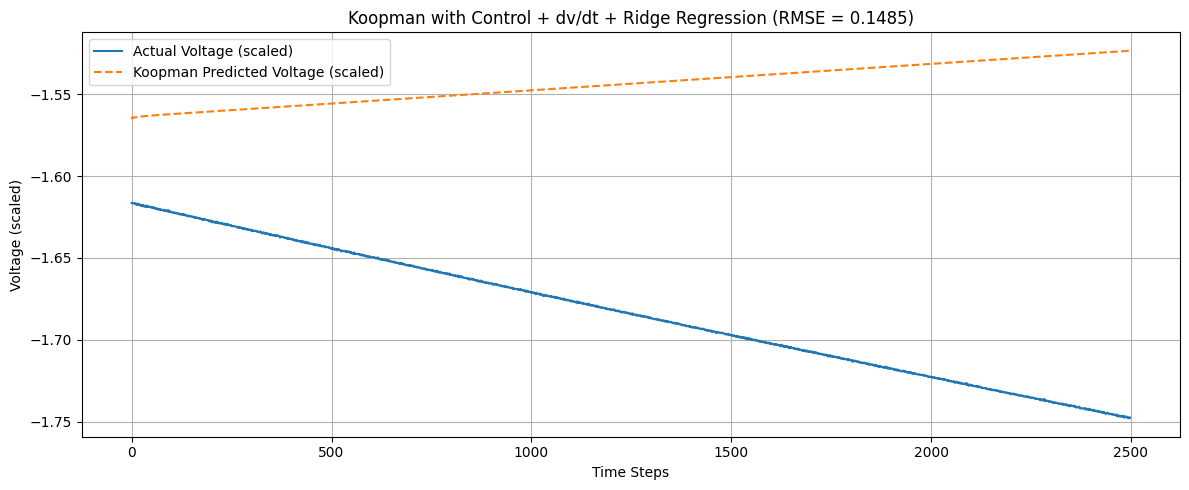

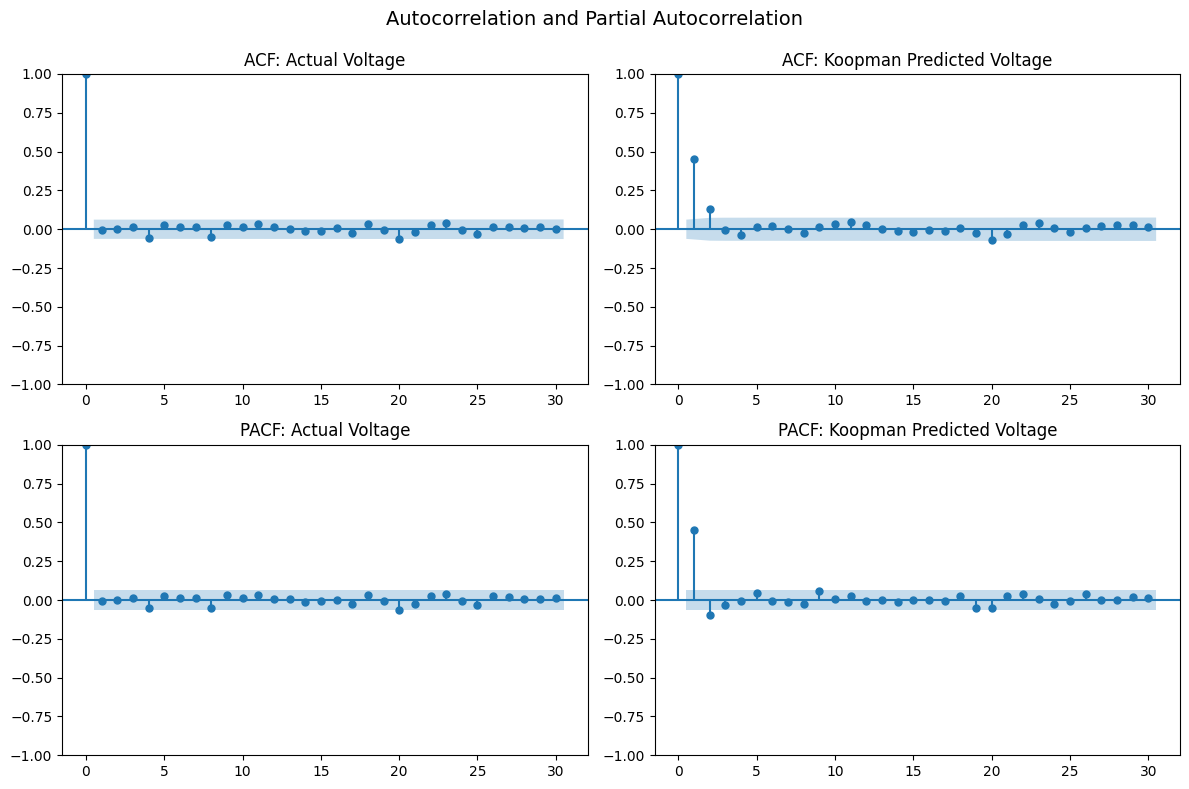

In [71]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ------------------- CONFIG -------------------
num_rbf_centers = 50
ridge_lambda = 1e-4
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- LOAD DATA -------------------
data = pd.read_csv("Combined_train_Data.csv")
file_path = "/content/Combined_train_Data.csv"
data = pd.read_csv(file_path).iloc[:50000]  # Limit data size to avoid OOM

voltage = data['Voltage_V'].values
current = data['Current_A'].values

# ------------------- FEATURE CONSTRUCTION -------------------
def build_state_dvdt_data(current, voltage):
    X, Y, U = [], [], []
    for t in range(1, len(current) - 1):
        v_prev = voltage[t - 1]
        dvdt = voltage[t] - voltage[t - 1]
        x_t = [v_prev, dvdt]
        x_tp1 = [voltage[t], voltage[t + 1] - voltage[t]]
        u_t = [current[t]]
        X.append(x_t)
        Y.append(x_tp1)
        U.append(u_t)
    return np.array(X), np.array(Y), np.array(U)

X_raw, y_raw, U_raw = build_state_dvdt_data(current, voltage)

# ------------------- SCALING -------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
scaler_U = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)
U_scaled = scaler_U.fit_transform(U_raw)

# ------------------- TRAIN / VAL SPLIT -------------------
split_idx = int(0.95 * len(X_scaled))
X_train = torch.tensor(X_scaled[:split_idx], dtype=torch.float32).to(device)
y_train = torch.tensor(y_scaled[:split_idx], dtype=torch.float32).to(device)
U_train = torch.tensor(U_scaled[:split_idx], dtype=torch.float32).to(device)
X_val = torch.tensor(X_scaled[split_idx:], dtype=torch.float32).to(device)
y_val = torch.tensor(y_scaled[split_idx:], dtype=torch.float32).to(device)
U_val = torch.tensor(U_scaled[split_idx:], dtype=torch.float32).to(device)

# ------------------- RBF LIFTING -------------------
dim_x = X_train.shape[1]
dim_u = U_train.shape[1]
centers = torch.tensor(np.random.uniform(low=-1.8, high=1.8, size=(num_rbf_centers, dim_x)), dtype=torch.float32).to(device)

def lift_polyharmonic(x, centers):
    lifted = []
    for sample in x:
        alpha = torch.sum((sample - centers) ** 2, dim=1)
        r = torch.sqrt(alpha + 1e-8)
        phi = r * torch.log(r + 1e-8)
        z = torch.cat([sample, phi])
        lifted.append(z)
    return torch.stack(lifted)

Z_train = lift_polyharmonic(X_train, centers)
Z_val = lift_polyharmonic(X_val, centers)

# ------------------- KOOPMAN REGRESSION -------------------
Z_curr = Z_train[:-1].T
Z_next = Z_train[1:].T
U_curr = U_train[:-1].T
ZU_combined = torch.cat([Z_curr, U_curr], dim=0).T
I_reg = ridge_lambda * torch.eye(ZU_combined.shape[1], device=device)
ZU_pinv = torch.linalg.pinv(ZU_combined.T @ ZU_combined + I_reg)
AB = (ZU_pinv @ ZU_combined.T @ Z_next.T).T
A = AB[:, :Z_curr.shape[0]]
B = AB[:, Z_curr.shape[0]:]

# ------------------- CLOSED-LOOP SIMULATION -------------------
z_pred = Z_val[0].unsqueeze(1)
Z_preds = []
for t in range(len(Z_val) - 1):
    u_t = U_val[t].unsqueeze(1)
    z_pred = A @ z_pred + B @ u_t
    z_pred = torch.clamp(z_pred, -10, 10)
    Z_preds.append(z_pred[:dim_x, 0].detach().cpu().numpy())

# ------------------- EVALUATE -------------------
Z_preds = np.array(Z_preds)
v_preds = Z_preds[:, 0]
v_actual = y_val[1:, 0].cpu().numpy()
rmse = np.sqrt(mean_squared_error(v_actual, v_preds))

# ------------------- PLOT -------------------
plt.figure(figsize=(12, 5))
plt.plot(v_actual, label="Actual Voltage (scaled)")
plt.plot(v_preds, '--', label="Koopman Predicted Voltage (scaled)")
plt.title(f"Koopman with Control + dv/dt + Ridge Regression (RMSE = {rmse:.4f})")
plt.xlabel("Time Steps")
plt.ylabel("Voltage (scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assume v_actual and v_preds (both scaled) are already defined in the Koopman pipeline

# For demonstration, simulate short sequences (replace these with actual model outputs in pipeline)
np.random.seed(42)
v_actual = np.random.normal(0, 1, 1000)
v_preds = np.convolve(v_actual, np.array([0.6, 0.3, 0.1]), mode='same')  # Mock Koopman-like smoothing

# Plot ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Autocorrelation and Partial Autocorrelation", fontsize=14)

# ACF
plot_acf(v_actual, ax=axes[0, 0], lags=30)
axes[0, 0].set_title("ACF: Actual Voltage")

plot_acf(v_preds, ax=axes[0, 1], lags=30)
axes[0, 1].set_title("ACF: Koopman Predicted Voltage")

# PACF
plot_pacf(v_actual, ax=axes[1, 0], lags=30, method='ywm')
axes[1, 0].set_title("PACF: Actual Voltage")

plot_pacf(v_preds, ax=axes[1, 1], lags=30, method='ywm')
axes[1, 1].set_title("PACF: Koopman Predicted Voltage")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



Deep Koopman

✅ Running on: cuda
Epoch 0, Train Loss: 2.8903, Val Loss: 1.9511
Epoch 10, Train Loss: 2.6014, Val Loss: 1.7512
Epoch 20, Train Loss: 2.3327, Val Loss: 1.5633
Epoch 30, Train Loss: 2.0840, Val Loss: 1.3892
Epoch 40, Train Loss: 1.8547, Val Loss: 1.2299
Epoch 50, Train Loss: 1.6441, Val Loss: 1.0858
Epoch 60, Train Loss: 1.4502, Val Loss: 0.9577
Epoch 70, Train Loss: 1.2721, Val Loss: 0.8457
Epoch 80, Train Loss: 1.1095, Val Loss: 0.7489
Epoch 90, Train Loss: 0.9624, Val Loss: 0.6658
Epoch 100, Train Loss: 0.8307, Val Loss: 0.5951
Epoch 110, Train Loss: 0.7139, Val Loss: 0.5349
Epoch 120, Train Loss: 0.6114, Val Loss: 0.4832
Epoch 130, Train Loss: 0.5225, Val Loss: 0.4383
Epoch 140, Train Loss: 0.4465, Val Loss: 0.3987
Epoch 150, Train Loss: 0.3826, Val Loss: 0.3633
Epoch 160, Train Loss: 0.3299, Val Loss: 0.3312
Epoch 170, Train Loss: 0.2868, Val Loss: 0.3017
Epoch 180, Train Loss: 0.2518, Val Loss: 0.2744
Epoch 190, Train Loss: 0.2231, Val Loss: 0.2491
Epoch 200, Train Loss: 0.1993, V

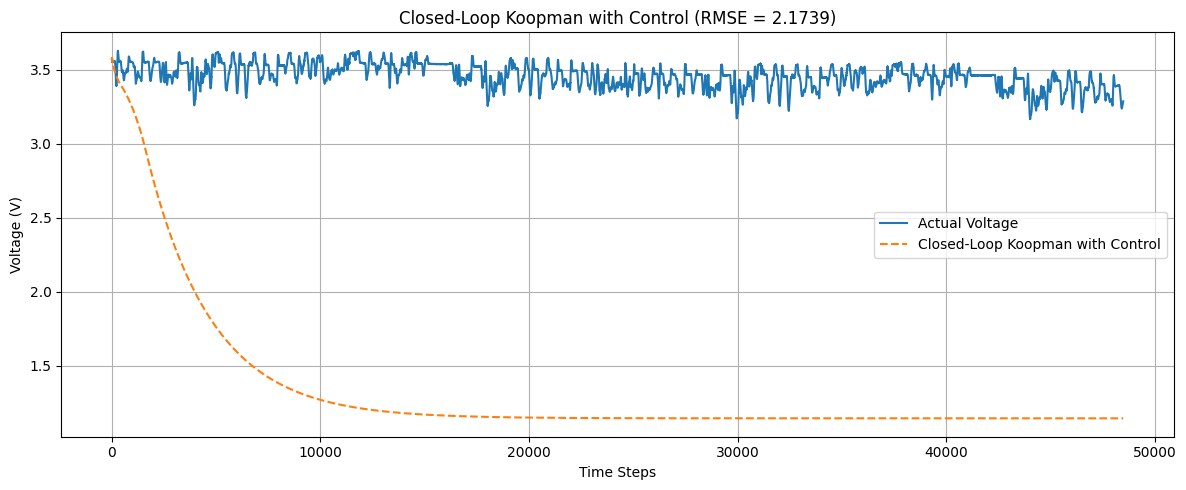

In [70]:
# ------------------- IMPORTS -------------------
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from google.colab import files

# ------------------- DEVICE -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Running on:", device)

# ------------------- LOAD DATA -------------------
data = pd.read_csv("Combined_train_Data.csv")
voltage = data['Voltage_V'].values
current = data['Current_A'].values

# ------------------- CONFIG -------------------
n_current_delays = 1
n_voltage_delays = 20
hidden_dim = 64
epochs = 1000
lr = 1e-4
patience = 10  # early stopping

# ------------------- NARX FORMAT -------------------
def build_narx_input(current, voltage, n_current_delays, n_voltage_delays):
    X, y = [], []
    max_delay = max(n_current_delays, n_voltage_delays)
    for t in range(max_delay, len(current)):
        I_window = current[t - n_current_delays : t + 1][::-1]
        V_window = voltage[t - n_voltage_delays : t][::-1]
        x_input = np.concatenate([I_window, V_window])
        X.append(x_input)
        y.append(voltage[t])
    return np.array(X), np.array(y)

X_raw, y_raw = build_narx_input(current, voltage, n_current_delays, n_voltage_delays)

# ------------------- NORMALIZATION -------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).flatten()

# ------------------- SPLIT -------------------
split_idx = int(0.95 * len(X_scaled))
X_train = torch.tensor(X_scaled[:split_idx], dtype=torch.float32).to(device)
y_train = torch.tensor(y_scaled[:split_idx], dtype=torch.float32).to(device)
X_val = torch.tensor(X_scaled[split_idx:], dtype=torch.float32).to(device)
y_val = torch.tensor(y_scaled[split_idx:], dtype=torch.float32).to(device)

# ------------------- CONTROL-AWARE DEEP KOOPMAN -------------------
class DeepKoopmanControl(nn.Module):
    def __init__(self, input_dim, control_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.voltage_head = nn.Linear(latent_dim, 1)

        self.A = nn.Parameter(torch.randn(latent_dim, latent_dim))
        self.B = nn.Parameter(torch.randn(latent_dim, control_dim))

    def forward(self, x, u):
        z = self.encoder(x)
        z_next = z @ self.A.T + u @ self.B.T
        voltage_pred = self.voltage_head(z_next)
        return voltage_pred.squeeze(), z, z_next

input_dim = X_train.shape[1]  # includes current and voltage delays
control_dim = n_current_delays + 1
latent_dim = 10
model = DeepKoopmanControl(input_dim, control_dim, hidden_dim, latent_dim).to(device)

# ------------------- TRAINING -------------------
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_fn = nn.MSELoss()

# Split control inputs (current) from X
def split_control(X):
    return X[:, :n_current_delays + 1]  # first part is current window

X_train_seq = X_train[:-1]
y_train_seq_next = y_train[1:]
X_val_seq = X_val[:-1]
y_val_seq_next = y_val[1:]

u_train_seq = split_control(X_train_seq)
u_val_seq = split_control(X_val_seq)

best_val_loss = float('inf')
best_model_state = None
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    voltage_pred, _, _ = model(X_train_seq, u_train_seq)
    loss = loss_fn(voltage_pred, y_train_seq_next)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        val_voltage_pred, _, _ = model(X_val_seq, u_val_seq)
        val_loss = loss_fn(val_voltage_pred, y_val_seq_next)

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        if epochs_no_improve >= patience:
            print("Early stopping at epoch", epoch)
            break

# ------------------- LOAD BEST MODEL -------------------
model.load_state_dict(best_model_state)
model.eval()

# ------------------- CLOSED-LOOP VALIDATION PREDICTION -------------------
with torch.no_grad():
    x_prev = X_val[0].unsqueeze(0)
    preds_cl = []
    for t in range(len(X_val) - 1):
        u_t = x_prev[:, :n_current_delays+1]
        v_pred, _, _ = model(x_prev, u_t)
        preds_cl.append(v_pred.item())

        # Update voltage window with prediction
        new_v_window = torch.cat([x_prev[0, n_current_delays+2:], v_pred.unsqueeze(0)])
        x_next = x_prev.clone()
        x_next[0, n_current_delays+1:] = new_v_window
        x_prev = x_next

# ------------------- EVALUATION -------------------
v_preds_cl = scaler_y.inverse_transform(np.array(preds_cl).reshape(-1, 1)).flatten()
v_actual_cl = scaler_y.inverse_transform(y_val[1:].cpu().numpy().reshape(-1, 1)).flatten()
rmse_cl = np.sqrt(mean_squared_error(v_actual_cl, v_preds_cl))

# ------------------- PLOT -------------------
plt.figure(figsize=(12, 5))
plt.plot(v_actual_cl, label="Actual Voltage")
plt.plot(v_preds_cl, '--', label="Closed-Loop Koopman with Control")
plt.title(f"Closed-Loop Koopman with Control (RMSE = {rmse_cl:.4f})")
plt.xlabel("Time Steps")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
